# Comparing simulated trajectories from coupled and uncoupled simulation

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import ticker
from matplotlib import colors
from matplotlib.offsetbox import AnchoredText
from matplotlib import cm
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram
import os.path
from datetime import timedelta, datetime
from geopy import distance
from glob import glob

## Loading trajectory data

In [2]:
datapath = '/Users/siren/IMMERSE_waves/develop-mac/data/TestIbiza/'

trajpaths_csd = sorted(glob(str(datapath + 
                                'Parcels_CalcTraj_Data-coupled-sd_Release-Ibiza-t*_Integrate-fw-d30-dt25m_Sample-tau-UV.nc')),
                       key=lambda f: int(''.join(filter(str.isdigit, f))))
traj_csd = xr.open_mfdataset(trajpaths_csd, concat_dim='start', combine='nested')

trajpaths_cnosd = sorted(glob(str(datapath + 
                                  'Parcels_CalcTraj_Data-coupled-nosd_Release-Ibiza-t*_Integrate-fw-d30-dt25m_Sample-tau-UV.nc')),
                         key=lambda f: int(''.join(filter(str.isdigit, f))))
traj_cnosd = xr.open_mfdataset(trajpaths_cnosd, concat_dim='start', combine='nested')

trajpaths_nc = sorted(glob(str(datapath + 'Parcels_CalcTraj_Data-uncoupled_Release-Ibiza-t*_Integrate-fw-d30-dt25m_Sample-tau-UV.nc')),
                      key=lambda f: int(''.join(filter(str.isdigit, f))))
traj_nc = xr.open_mfdataset(trajpaths_nc, concat_dim='start', combine='nested')

trajpaths_ncsd = sorted(glob(str(datapath + 'Parcels_CalcTraj_Data-uncoupled-sd_Release-Ibiza-t*_Integrate-fw-d30-dt25m_Sample-tau-UV.nc')),
                        key=lambda f: int(''.join(filter(str.isdigit, f))))
traj_ncsd = xr.open_mfdataset(trajpaths_ncsd, concat_dim='start', combine='nested')

datapath2 = '/Users/siren/Data/IMMERSE/'
gridpath = (datapath2 + 'domain/mesh_mask.nc')
grid = xr.open_dataset(gridpath, drop_variables=('x','y'))

## Check whether particles beached

In [3]:
def calc_npaticles_beached(trajset):
    tmp = trajset.beached.sum(dim=('obs'))
    beached_trajset = (tmp.where(tmp != 0) / tmp.where(tmp != 0)).sum()
    return beached_trajset.values

In [4]:
npart = traj_csd.lat.shape[0] * traj_csd.lat.shape[1]
print('Total number of released particles per dataset:', str(npart))
print('number of beached particles:')
print('coupled with Stokes drift:', str(calc_npaticles_beached(traj_csd)),
      ' (', str(round(calc_npaticles_beached(traj_csd)/npart*100)), '%)')
print('coupled without Stokes drift:', str(calc_npaticles_beached(traj_cnosd)),
      ' (', str(round(calc_npaticles_beached(traj_cnosd)/npart*100)), '%)' )
print('uncoupled without Stokes drift:', str(calc_npaticles_beached(traj_nc)),
      ' (', str(round(calc_npaticles_beached(traj_nc)/npart*100)), '%)' )
print('uncoupled with Stokes drift:', str(calc_npaticles_beached(traj_nc)),
      ' (', str(round(calc_npaticles_beached(traj_nc)/npart*100)), '%)' )

Total number of released particles per dataset: 4453
number of beached particles:
coupled with Stokes drift: 1.0  ( 0 %)
coupled without Stokes drift: 1.0  ( 0 %)
uncoupled without Stokes drift: 1.0  ( 0 %)
uncoupled with Stokes drift: 1.0  ( 0 %)


## Estimating impact of ocean-wave coupling on general dispersion statistics

In [5]:
def calc_trajspeed(trajset):
    u = trajset.U * 1852*60 * np.cos(trajset.lat * np.pi/180)
    v = trajset.V * 1852*60
    speed = (u**2 + v**2)**(1/2)
    return speed

In [6]:
trajspeed_csd = calc_trajspeed(traj_csd)
trajspeed_cnosd = calc_trajspeed(traj_cnosd)
trajspeed_nc = calc_trajspeed(traj_nc)
trajspeed_ncsd = calc_trajspeed(traj_ncsd)

In [7]:
def calc_displacement_stats(trajspeed,dtout):
    #dtout is the output frequency in seconds
    # 1. Total displacement for each particle
    ## obtained by integrating over along-track velocities
    dist = ((trajspeed * dtout).cumsum(dim='obs', skipna=True)) # in m
    # 2. Residual displacement 
    ## obtained by subtracting the mean displacement of all particles
    Dist_total = dist.mean(dim=['traj','start'])
    resdist_total = dist - Dist_total
    # 2. Residual displacement - time
    ## obtained by subtracting the mean displacement D of all particles
    ## - released at the same location
    ## - but at different start times
    Dist_time = dist.mean(dim=['start'])
    resdist_time = dist - Dist_time
    # 2. Residual displacement - space
    ## obtained by subtracting the mean displacement of all particles
    ## - released at the same start time
    ## - but at all possible locations  
    Dist_space = dist.mean(dim=['traj'])
    resdist_space = dist - Dist_space
    return dist, resdist_total, resdist_time, resdist_space

In [8]:
dist_csd, resdist_total_csd, resdist_time_csd, resdist_space_csd = calc_displacement_stats(trajspeed_csd,86400)
dist_cnosd, resdist_total_cnosd, resdist_time_cnosd, resdist_space_cnosd = calc_displacement_stats(trajspeed_cnosd,86400)
dist_nc, resdist_total_nc, resdist_time_nc, resdist_space_nc = calc_displacement_stats(trajspeed_nc,86400)
dist_ncsd, resdist_total_ncsd, resdist_time_ncsd, resdist_space_ncsd = calc_displacement_stats(trajspeed_ncsd,86400)

In [9]:
def calc_quantiles(trajdist):
    dist_quantiles = trajdist.chunk(dict(start=-1)).quantile(q=[0, 0.25, 0.5, 0.75, 1], dim=('traj','start'))
    return dist_quantiles

In [10]:
dist_csd_quantiles = calc_quantiles(dist_csd).compute()
resdist_total_csd_quantiles = calc_quantiles(abs(resdist_total_csd)).compute()
resdist_space_csd_quantiles = calc_quantiles(abs(resdist_space_csd)).compute()
resdist_time_csd_quantiles = calc_quantiles(abs(resdist_time_csd)).compute()

dist_cnosd_quantiles = calc_quantiles(dist_cnosd).compute()
resdist_total_cnosd_quantiles = calc_quantiles(abs(resdist_total_cnosd)).compute()
resdist_space_cnosd_quantiles = calc_quantiles(abs(resdist_space_cnosd)).compute()
resdist_time_cnosd_quantiles = calc_quantiles(abs(resdist_time_cnosd)).compute()

dist_nc_quantiles = calc_quantiles(dist_nc).compute()
resdist_total_nc_quantiles = calc_quantiles(abs(resdist_total_nc)).compute()
resdist_space_nc_quantiles = calc_quantiles(abs(resdist_space_nc)).compute()
resdist_time_nc_quantiles = calc_quantiles(abs(resdist_time_nc)).compute()

dist_ncsd_quantiles = calc_quantiles(dist_ncsd).compute()
resdist_total_ncsd_quantiles = calc_quantiles(abs(resdist_total_ncsd)).compute()
resdist_space_ncsd_quantiles = calc_quantiles(abs(resdist_space_ncsd)).compute()
resdist_time_ncsd_quantiles = calc_quantiles(abs(resdist_time_ncsd)).compute()

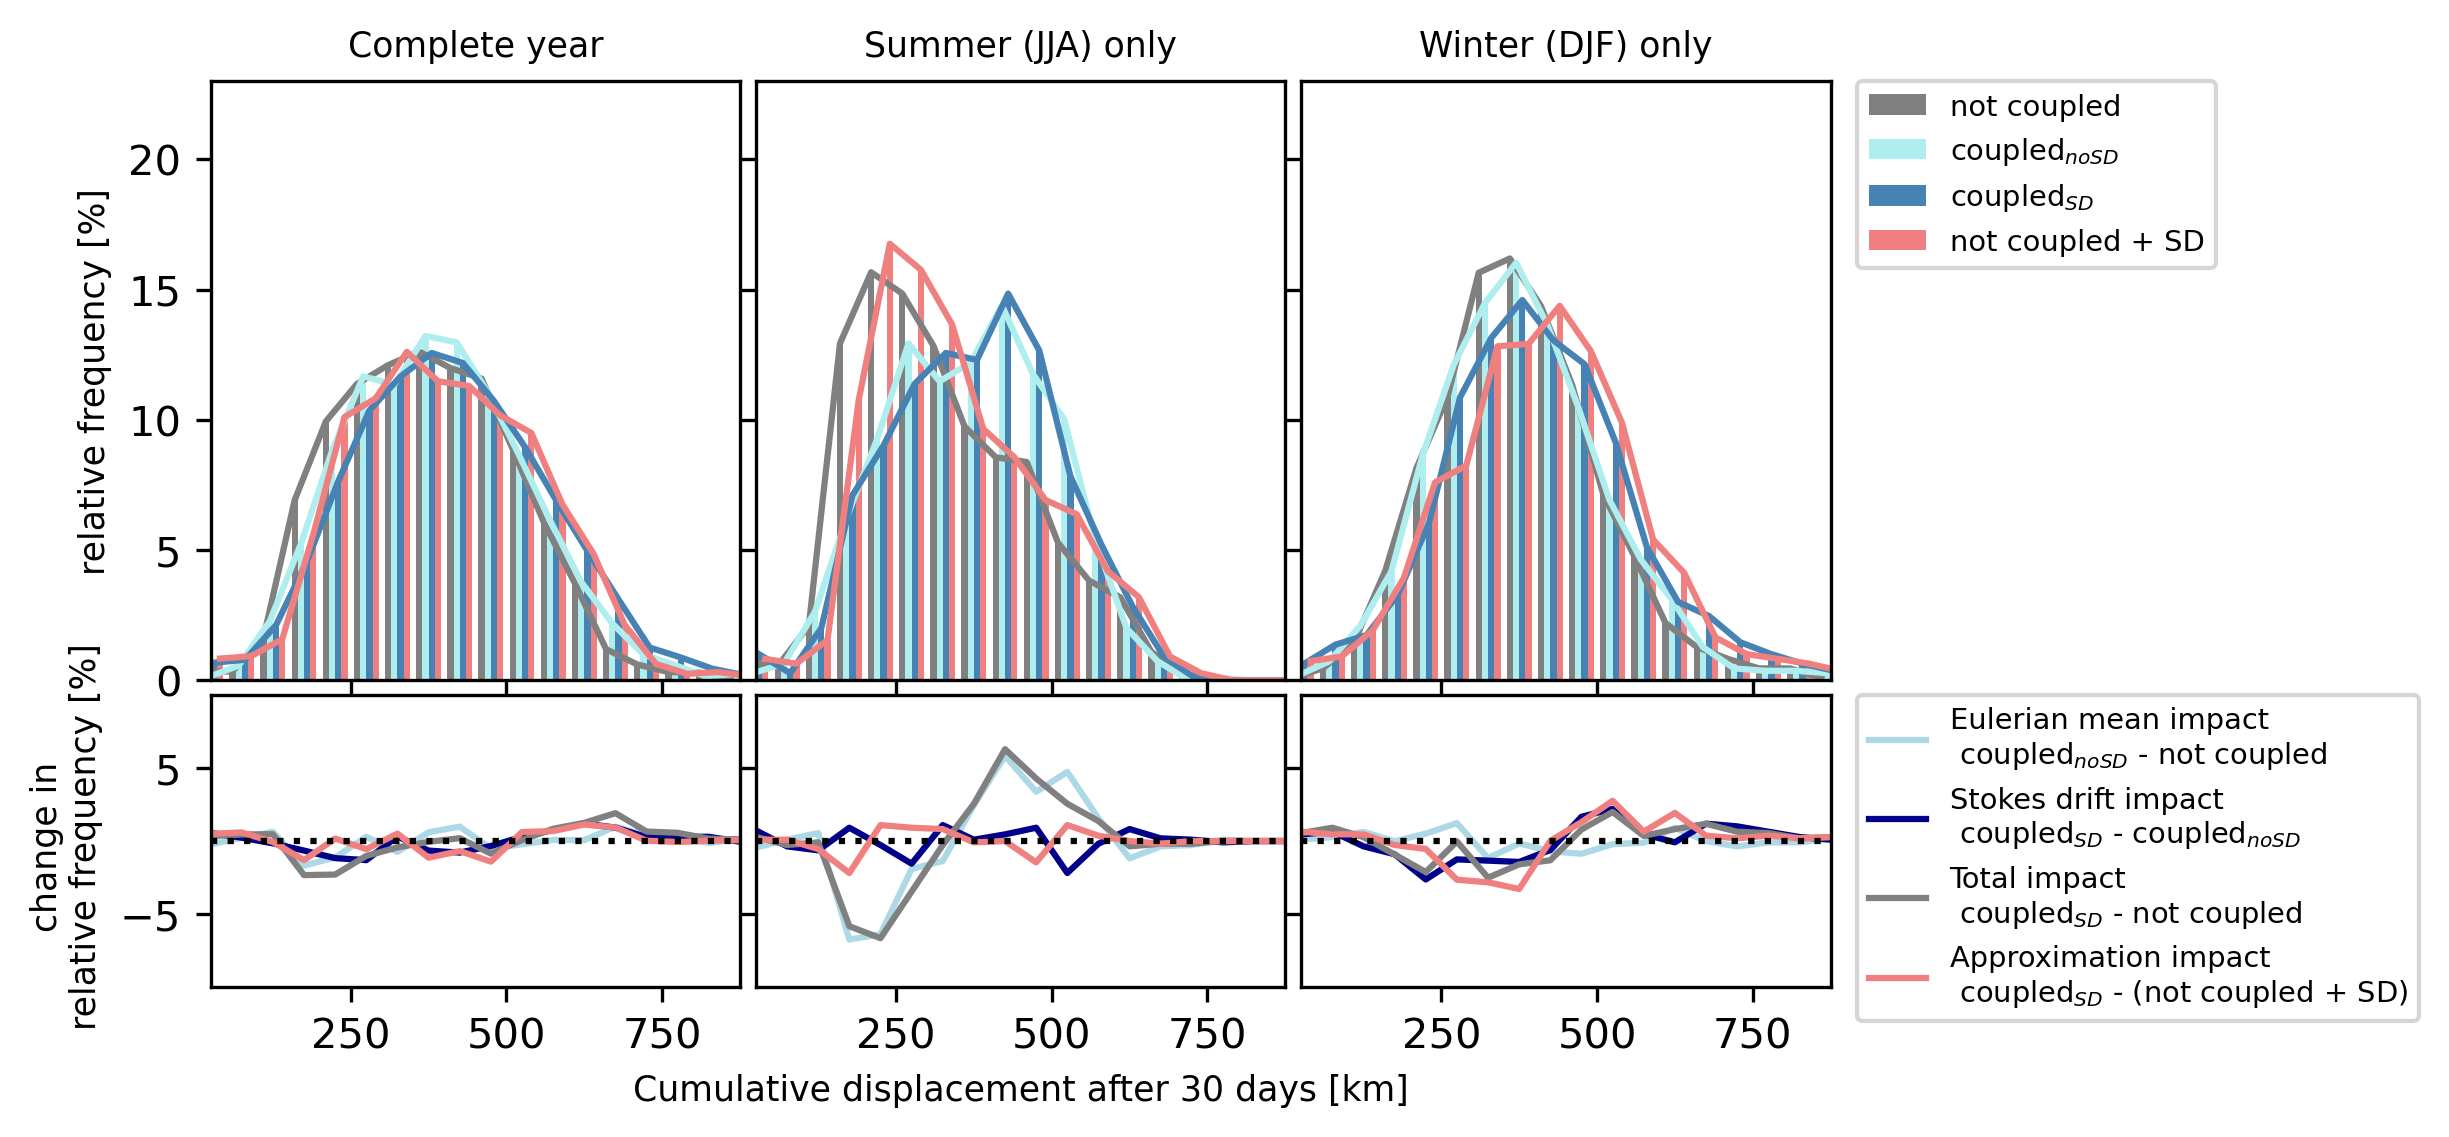

In [11]:
bins = np.arange(0,950,50)
col1 = 'steelblue'
col2 = 'paleturquoise'
col3 = 'grey'
col4 = 'lightcoral'
bar_width = 10
lw1 = 1.5
fs = 'small'
fs2 = 'x-small'
tobs = 30


fig = plt.figure(figsize=(6,4), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=3, 
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.05)


# Distribution release whole year

var1 = dist_csd.rename('dist').isel(obs=tobs).stack(trajstack=('traj','start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs).stack(trajstack=('traj','start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs).stack(trajstack=('traj','start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs).stack(trajstack=('traj','start'))/1000    
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-1,0])
def plot_histcounts():
    plt.bar(hist3b.dist_bin-15, hist3b.values, 
            width=bar_width, color=col3,
            label='not coupled')
    plt.bar(hist2b.dist_bin-5, hist2b.values, 
            width=bar_width, color=col2,
            label='coupled$_{noSD}$')
    plt.bar(hist1b.dist_bin+5, hist1b.values, 
            width=bar_width, color=col1,
            label='coupled$_{SD}$')
    plt.bar(hist4b.dist_bin+15, hist4b.values, 
            width=bar_width, color=col4,
            label='not coupled + SD')
    ax.plot(hist3b.dist_bin-15,hist3b, color=col3, linewidth=lw1)
    ax.plot(hist2b.dist_bin-5,hist2b, color=col2, linewidth=lw1)
    ax.plot(hist1b.dist_bin+5,hist1b, color=col1, linewidth=lw1)
    ax.plot(hist4b.dist_bin+15,hist4b, color=col4, linewidth=lw1)
    ax.set_xlim([25,875])
    ax.set_ylim([0,23])
plot_histcounts()
ax.set_ylabel('relative frequency [%]', fontsize=fs)
ax.set_title('Complete year', fontsize=fs)

ax = fig.add_subplot(gs[2,0])
def plot_histdiff():
    ax.plot(hist1b.dist_bin,hist2b-hist3b,
            color='lightblue', linewidth=lw1, label='Eulerian mean impact \n coupled$_{noSD}$ - not coupled')
    ax.plot(hist1b.dist_bin,hist1b-hist2b,
            color='darkblue', linewidth=lw1, label='Stokes drift impact \n coupled$_{SD}$ - coupled$_{noSD}$')
    ax.plot(hist1b.dist_bin,hist1b-hist3b,
            color='grey', linewidth=lw1, label='Total impact \n coupled$_{SD}$ - not coupled')
    ax.plot(hist1b.dist_bin,hist4b-hist3b,
            color='lightcoral', linewidth=lw1, label='Approximation impact \n coupled$_{SD}$ - (not coupled + SD)')
    ax.plot(hist1b.dist_bin,hist1b.dist_bin*0,
            color='k', linestyle='dotted', linewidth=lw1)
    ax.set_xlim([25,875])
    ax.set_ylim([-10,10])
    ax.set_yticks([-5,5])
plot_histdiff()
ax.set_ylabel('change in \n relative frequency [%]', fontsize=fs)


# Distribution summer

var1 = dist_csd.rename('dist').isel(obs=tobs,start=slice(31,49)).stack(trajstack=('traj','start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs,start=slice(31,49)).stack(trajstack=('traj','start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs,start=slice(31,49)).stack(trajstack=('traj','start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs,start=slice(31,49)).stack(trajstack=('traj','start'))/1000
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-1,1])
plot_histcounts()
ax.set_yticklabels([])
ax.set_title('Summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[2,1])
plot_histdiff()
ax.set_yticklabels([])
ax.set_xlabel('Cumulative displacement after 30 days [km]', fontsize=fs)

# Distribution winter

l1 = np.arange(0,12)
l2 = np.arange(67,73)
l3 = [*l1, *l2]
var1 = dist_csd.rename('dist').isel(obs=tobs,start=l3).stack(trajstack=('traj','start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs,start=l3).stack(trajstack=('traj','start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs,start=l3).stack(trajstack=('traj','start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs,start=l3).stack(trajstack=('traj','start'))/1000
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-1,2])
plot_histcounts()
ax.set_yticklabels([])
ax.set_title('Winter (DJF) only', fontsize=fs)
ax.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0., fontsize=fs2)

ax = fig.add_subplot(gs[2,2])
plot_histdiff()
ax.set_yticklabels([])
ax.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0., fontsize=fs2)

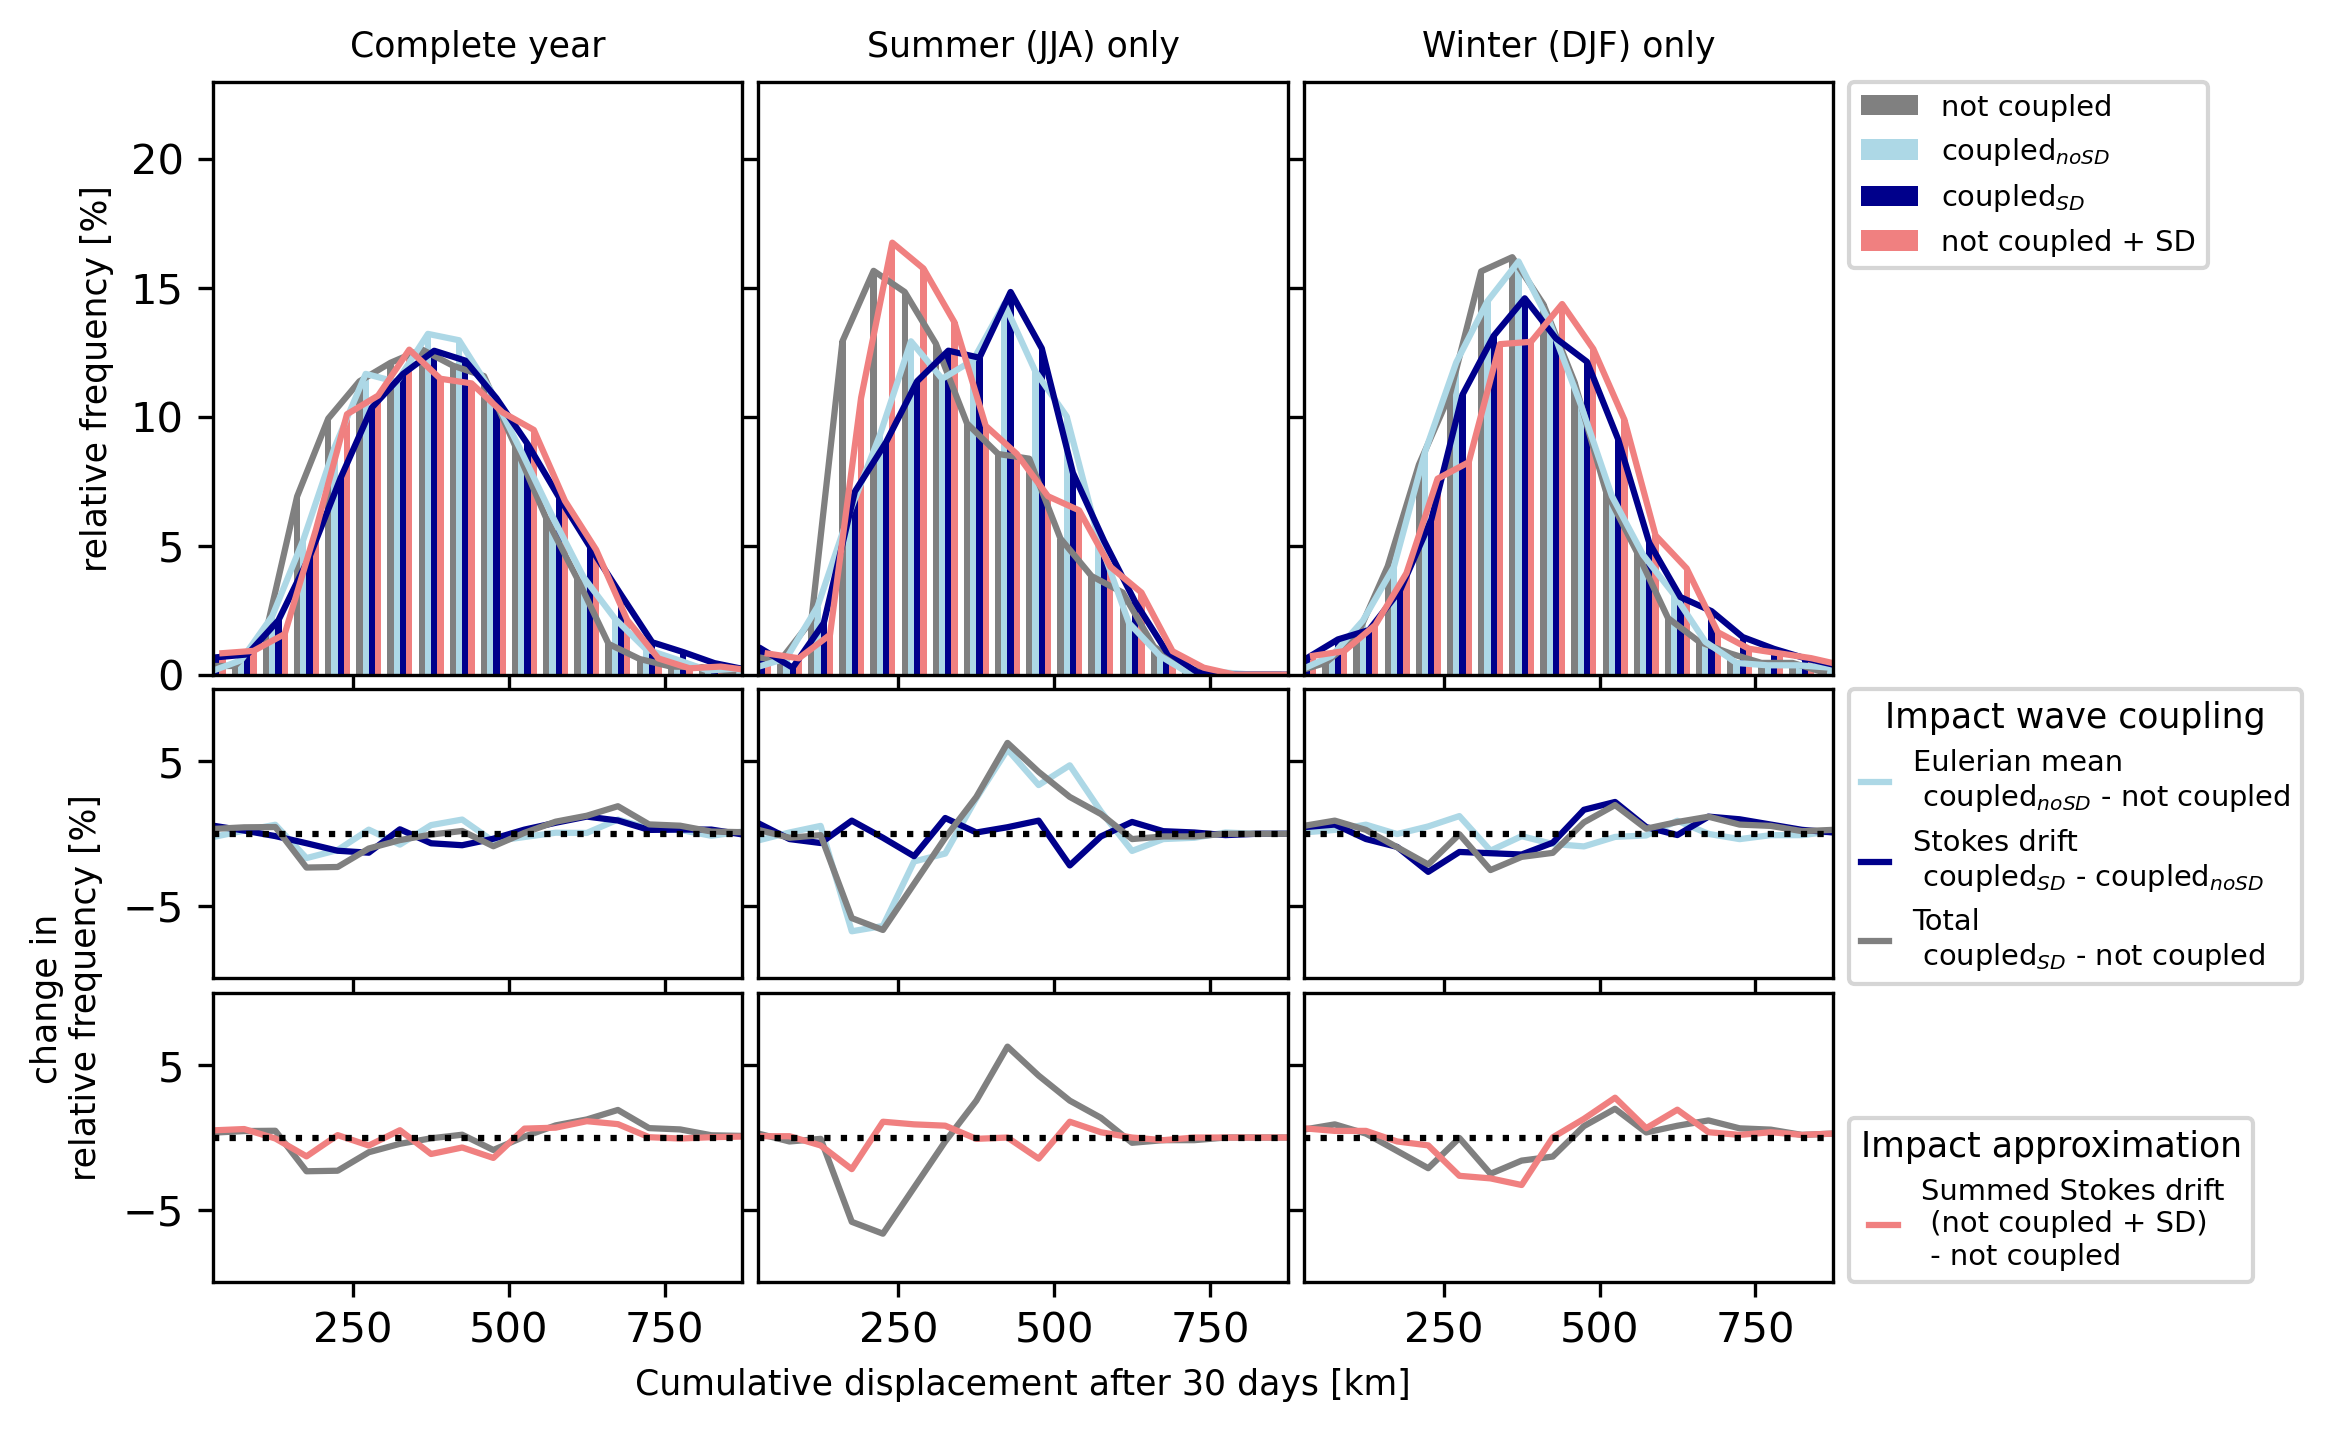

In [12]:
bins = np.arange(0,950,50)
col1 = 'darkblue' #'steelblue'
col2 = 'lightblue' #'turquoise' #'paleturquoise'
col3 = 'grey'
col4 = 'lightcoral' #'crimson' #'lightcoral'
bar_width = 10
lw1 = 1.5
fs = 'small'
fs2 = 'x-small'
tobs = 30


fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.05)


# Distribution release whole year

var1 = dist_csd.rename('dist').isel(obs=tobs).stack(trajstack=('traj','start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs).stack(trajstack=('traj','start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs).stack(trajstack=('traj','start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs).stack(trajstack=('traj','start'))/1000    
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,0])
def plot_histcounts():
    plt.bar(hist3b.dist_bin-15, hist3b.values, 
            width=bar_width, color=col3,
            label='not coupled')
    plt.bar(hist2b.dist_bin-5, hist2b.values, 
            width=bar_width, color=col2,
            label='coupled$_{noSD}$')
    plt.bar(hist1b.dist_bin+5, hist1b.values, 
            width=bar_width, color=col1,
            label='coupled$_{SD}$')
    plt.bar(hist4b.dist_bin+15, hist4b.values, 
            width=bar_width, color=col4,
            label='not coupled + SD')
    ax.plot(hist3b.dist_bin-15,hist3b, color=col3, linewidth=lw1)
    ax.plot(hist2b.dist_bin-5,hist2b, color=col2, linewidth=lw1)
    ax.plot(hist1b.dist_bin+5,hist1b, color=col1, linewidth=lw1)
    ax.plot(hist4b.dist_bin+15,hist4b, color=col4, linewidth=lw1)
    ax.set_xlim([25,875])
    ax.set_ylim([0,23])
plot_histcounts()
ax.set_ylabel('relative frequency [%]', fontsize=fs)
ax.set_title('Complete year', fontsize=fs)

ax = fig.add_subplot(gs[2,0])
def plot_histdiff():
    ax.plot(hist1b.dist_bin,hist2b-hist3b,
            color='lightblue', linewidth=lw1, label='Eulerian mean \n coupled$_{noSD}$ - not coupled')
    ax.plot(hist1b.dist_bin,hist1b-hist2b,
            color='darkblue', linewidth=lw1, label='Stokes drift \n coupled$_{SD}$ - coupled$_{noSD}$')
    ax.plot(hist1b.dist_bin,hist1b-hist3b,
            color='grey', linewidth=lw1, label='Total \n coupled$_{SD}$ - not coupled')
    ax.plot(hist1b.dist_bin,hist1b.dist_bin*0,
            color='k', linestyle='dotted', linewidth=lw1)
    ax.set_xlim([25,875])
    ax.set_ylim([-10,10])
    ax.set_yticks([-5,5])
plot_histdiff()

ax = fig.add_subplot(gs[3,0])
def plot_histdiff2():
    ax.plot(hist1b.dist_bin,hist1b-hist3b,
            color='grey', linewidth=lw1)
    ax.plot(hist1b.dist_bin,hist4b-hist3b,
            color='lightcoral', linewidth=lw1, label='Summed Stokes drift \n (not coupled + SD) \n - not coupled')
    ax.plot(hist1b.dist_bin,hist1b.dist_bin*0,
            color='k', linestyle='dotted', linewidth=lw1)
    ax.set_xlim([25,875])
    ax.set_ylim([-10,10])
    ax.set_yticks([-5,5])
plot_histdiff2()
ax.text(-210,10,'change in \n relative frequency [%]',
        fontsize=fs, rotation=90, ha='center', va='center' )


# Distribution summer

var1 = dist_csd.rename('dist').isel(obs=tobs,start=slice(31,49)).stack(trajstack=('traj','start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs,start=slice(31,49)).stack(trajstack=('traj','start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs,start=slice(31,49)).stack(trajstack=('traj','start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs,start=slice(31,49)).stack(trajstack=('traj','start'))/1000
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,1])
plot_histcounts()
ax.set_yticklabels([])
ax.set_title('Summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[2,1])
plot_histdiff()
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(gs[3,1])
plot_histdiff2()
ax.set_yticklabels([])
ax.set_xlabel('Cumulative displacement after 30 days [km]',fontsize=fs)


# Distribution winter

l1 = np.arange(0,12)
l2 = np.arange(67,73)
l3 = [*l1, *l2]
var1 = dist_csd.rename('dist').isel(obs=tobs,start=l3).stack(trajstack=('traj','start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs,start=l3).stack(trajstack=('traj','start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs,start=l3).stack(trajstack=('traj','start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs,start=l3).stack(trajstack=('traj','start'))/1000
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,2])
plot_histcounts()
ax.set_yticklabels([])
ax.set_title('Winter (DJF) only', fontsize=fs)
ax.legend(bbox_to_anchor=(1.03, 1),
                         loc='upper left', borderaxespad=0., fontsize=fs2)

ax = fig.add_subplot(gs[2,2])
plot_histdiff()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.legend(bbox_to_anchor=(1.03, 1),loc='upper left', 
          title='Impact wave coupling', title_fontsize=fs,
          borderaxespad=0., fontsize=fs2,
          handlelength=1)

ax = fig.add_subplot(gs[3,2])
plot_histdiff2()
ax.set_yticklabels([])
ax.legend(bbox_to_anchor=(1.03, 0),loc='lower left', 
          title='Impact approximation', title_fontsize=fs,
          borderaxespad=0., fontsize=fs2,
          handlelength=1)

In [ ]:
#def calc_finaldist(trajset,tfinal): 
#    lat1 = trajset.isel(obs=0).lat.stack(trajstack=('traj','start'))
#    lat2 = trajset.isel(obs=tfinal).lat.stack(trajstack=('traj','start'))
#    lon1 = trajset.isel(obs=0).lon.stack(trajstack=('traj','start'))
#    lon2 = trajset.isel(obs=tfinal).lon.stack(trajstack=('traj','start'))
#    finaldist = lat1.copy()
#    for i in range(lat1.size):
#        finaldist[i] = distance.distance((lat1.isel(trajstack=i), lon1.isel(trajstack=i)),
#                                         (lat2.isel(trajstack=i), lon2.isel(trajstack=i))).km
#    return finaldist
#test = calc_finaldist(traj_csd,30)

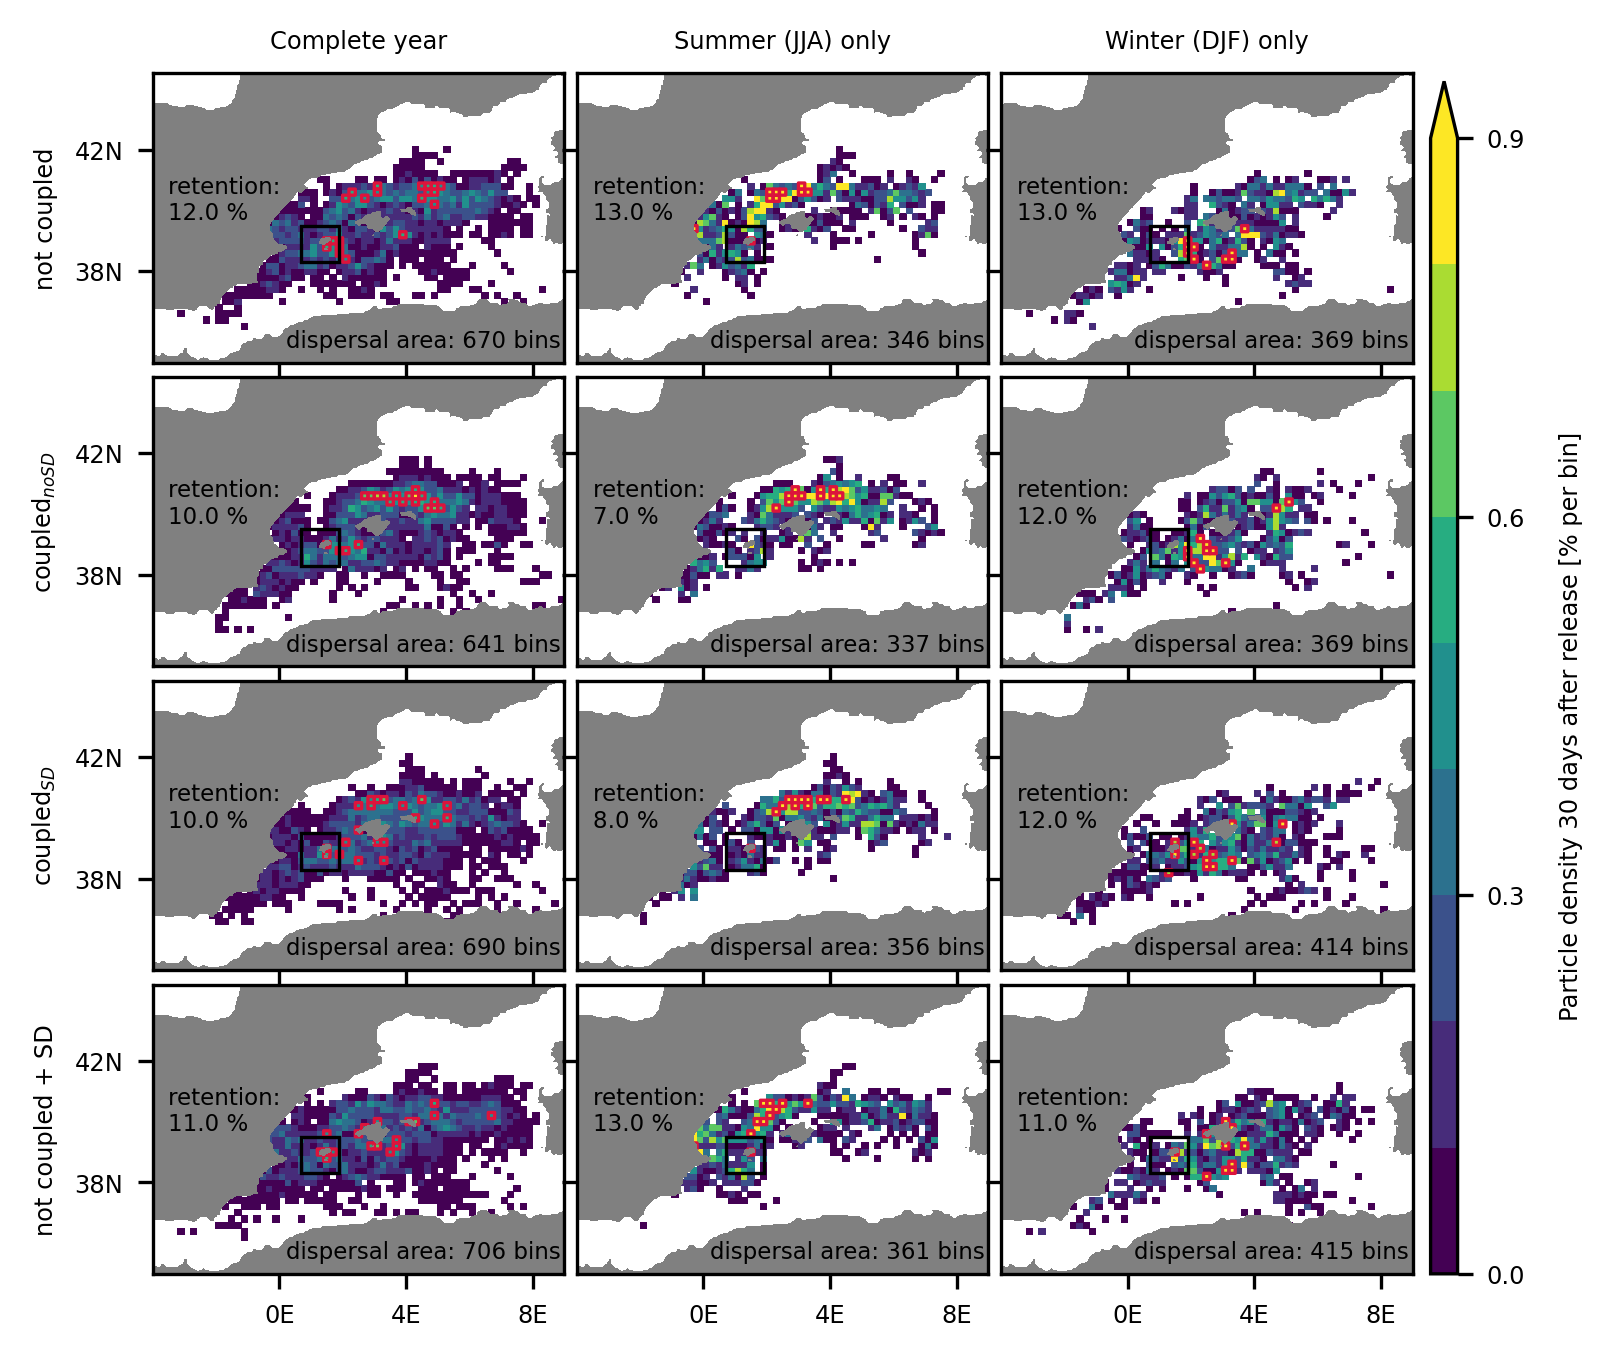

In [42]:
bins_lon = np.arange(-8,36,0.2); bins_lat =  np.arange(30.1,47,0.2)
lonmin = 0.7
lonmax = 1.901
latmin = 38.3
latmax = 39.5
step = 0.2
lonmin_plot = -4
lonmax_plot = 9
latmin_plot = 35
latmax_plot = 44.5
col_nc = 'grey'
col_csd = 'darkblue'
col_cnosd = 'lightblue'
col_ncsd = 'lightcoral'

colm = cm.viridis #cm.cool 
levs = np.arange(0, 1, 0.1)
norm = colors.BoundaryNorm(boundaries=levs, ncolors=colm.N)
#norm = colors.LogNorm(vmin=0, vmax=1)
fs='xx-small'
nctic=3

def plot_2Dhist(var1):
    pos_y = var1.isel(obs=30).lat.stack(trajstack=('traj','start'))
    pos_x = var1.isel(obs=30).lon.stack(trajstack=('traj','start'))
    #pos_y = var1.lat.stack(trajstack=('traj','start','obs'))
    #pos_x = var1.lon.stack(trajstack=('traj','start','obs'))
    hist2D = histogram(pos_x, pos_y, bins=[bins_lon, bins_lat])
    hist2D_plot = hist2D.transpose()/hist2D.sum().values*100
    map = ax.pcolor(hist2D_plot.lon_bin, hist2D_plot.lat_bin,
                    hist2D_plot.where(hist2D_plot != 0),
                    cmap=colm, norm = norm,
                    shading='nearest')
    release_box = (((hist2D_plot.lon_bin >= lonmin) & (hist2D_plot.lon_bin <= lonmax)) &
                   ((hist2D_plot.lat_bin >= latmin) & (hist2D_plot.lat_bin <= latmax)))
    tmp = hist2D_plot.where(release_box)
    retention = tmp.sum()
    ax.annotate('retention: \n' + str(retention.round().values) + ' %', (-3.5, latmax+step), fontsize=5.5)
    area_bins = (hist2D_plot.where(hist2D_plot != 0)/hist2D_plot.where(hist2D_plot != 0)).sum()
    ax.text(0.2, 35.5, 'dispersal area: ' + str(int(area_bins.round().values)) + ' bins', fontsize=5.5)
    tmp2 = np.sort(hist2D_plot.stack(binstack=('lon_bin','lat_bin')))
    tmp3 = np.cumsum(tmp2)
    highprob = xr.DataArray(tmp2).where(tmp3 >= 90).squeeze(drop=True).min()
    ax.pcolor(hist2D_plot.lon_bin, hist2D_plot.lat_bin,
              hist2D_plot.where(hist2D_plot >= highprob),
              alpha=1.0, edgecolor='crimson', facecolor='none',
              linewidth=0.8,
              shading='nearest')
    del tmp, tmp2, tmp3
    return map
    
def plot_maxdisttraj(var1, var2, speccolor):
    ind_max = var2.isel(obs=30).stack(trajstack=('traj','start')).argmax().values
    tmp = var1.stack(trajstack=('traj','start'))
    traj_plot_lat = tmp.lat.isel(trajstack=ind_max)
    traj_plot_lon = tmp.lon.isel(trajstack=ind_max)
    ax.plot(traj_plot_lon.values,traj_plot_lat.values,
            color=speccolor, linewidth=0.8)
    ax.plot(traj_plot_lon.isel(obs=30).values,traj_plot_lat.isel(obs=30).values,
            color=speccolor, marker='o', markersize=1.5)

def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')

def plot_releasebox():
    rect = patches.Rectangle((lonmin, latmin), lonmax-lonmin, latmax-latmin, 
                             linewidth=0.8,edgecolor='k', facecolor='none')
    ax.add_patch(rect)

def build_subplot(var1,var2,speccolor,xticklabel=True,yticklabel=True):
    map = plot_2Dhist(var1)
    #plot_maxdisttraj(var1,var2,speccolor)
    plot_bathy()
    plot_releasebox()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks([0,4,8])
    ax.set_yticks([38,42])
    ax.set_xticklabels(['0E','4E','8E'])
    ax.set_yticklabels(['38N','42N'])
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map

    
fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.1, right=0.8,
                      wspace=0.03, hspace=0.05)


# Totel distributions

ax = fig.add_subplot(gs[0,0])
var1 = traj_nc
var2 = dist_nc
map = build_subplot(var1,var2,col_nc, xticklabel=False)
ax.set_title('Complete year', fontsize=fs)
ax.set_ylabel('not coupled', fontsize=fs)

ax = fig.add_subplot(gs[1,0])
var1 = traj_cnosd
var2 = dist_cnosd
map = build_subplot(var1,var2,col_cnosd, xticklabel=False)
ax.set_ylabel('coupled$_{noSD}$', fontsize=fs)

ax = fig.add_subplot(gs[2,0])
var1 = traj_csd
var2 = dist_csd
map = build_subplot(var1,var2,col_csd, xticklabel=False)
ax.set_ylabel('coupled$_{SD}$', fontsize=fs)

ax = fig.add_subplot(gs[3,0])
var1 = traj_ncsd
var2 = dist_ncsd
map = build_subplot(var1,var2,col_ncsd)
ax.set_ylabel('not coupled + SD', fontsize=fs)

# Summer distributions

start_use = slice(31,49)

ax = fig.add_subplot(gs[0,1])
var1 = traj_nc.isel(start=start_use)
var2 = dist_nc.isel(start=start_use)
map = build_subplot(var1,var2,col_nc, xticklabel=False, yticklabel=False)
ax.set_title('Summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[1,1])
var1 = traj_cnosd.isel(start=start_use)
var2 = dist_cnosd.isel(start=start_use)
map = build_subplot(var1,var2,col_cnosd, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[2,1])
var1 = traj_csd.isel(start=start_use)
var2 = dist_csd.isel(start=start_use)
map = build_subplot(var1,var2,col_csd, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3,1])
var1 = traj_ncsd.isel(start=start_use)
var2 = dist_ncsd.isel(start=start_use)
map = build_subplot(var1,var2,col_ncsd, yticklabel=False)


# Winter distributions

start1 = np.arange(0,12); start2 = np.arange(67,73); start_use = [*l1, *l2]

ax = fig.add_subplot(gs[0,2])
var1 = traj_nc.isel(start=start_use)
var2 = dist_nc.isel(start=start_use)
map = build_subplot(var1,var2,col_nc, xticklabel=False, yticklabel=False)
ax.set_title('Winter (DJF) only', fontsize=fs)

ax = fig.add_subplot(gs[1,2])
var1 = traj_cnosd.isel(start=start_use)
var2 = dist_cnosd.isel(start=start_use)
map = build_subplot(var1,var2,col_cnosd, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[2,2])
var1 = traj_csd.isel(start=start_use)
var2 = dist_csd.isel(start=start_use)
map = build_subplot(var1,var2,col_csd, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3,2])
var1 = traj_ncsd.isel(start=start_use)
var2 = dist_ncsd.isel(start=start_use)
map = build_subplot(var1,var2,col_ncsd, yticklabel=False)
ax.text(14, 53, 'Particle density 30 days after release [% per bin]',
        ha='center', va='center', fontsize=fs, rotation=90)
cbaxes = fig.add_axes([0.81, 0.125, 0.015, 0.75])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()


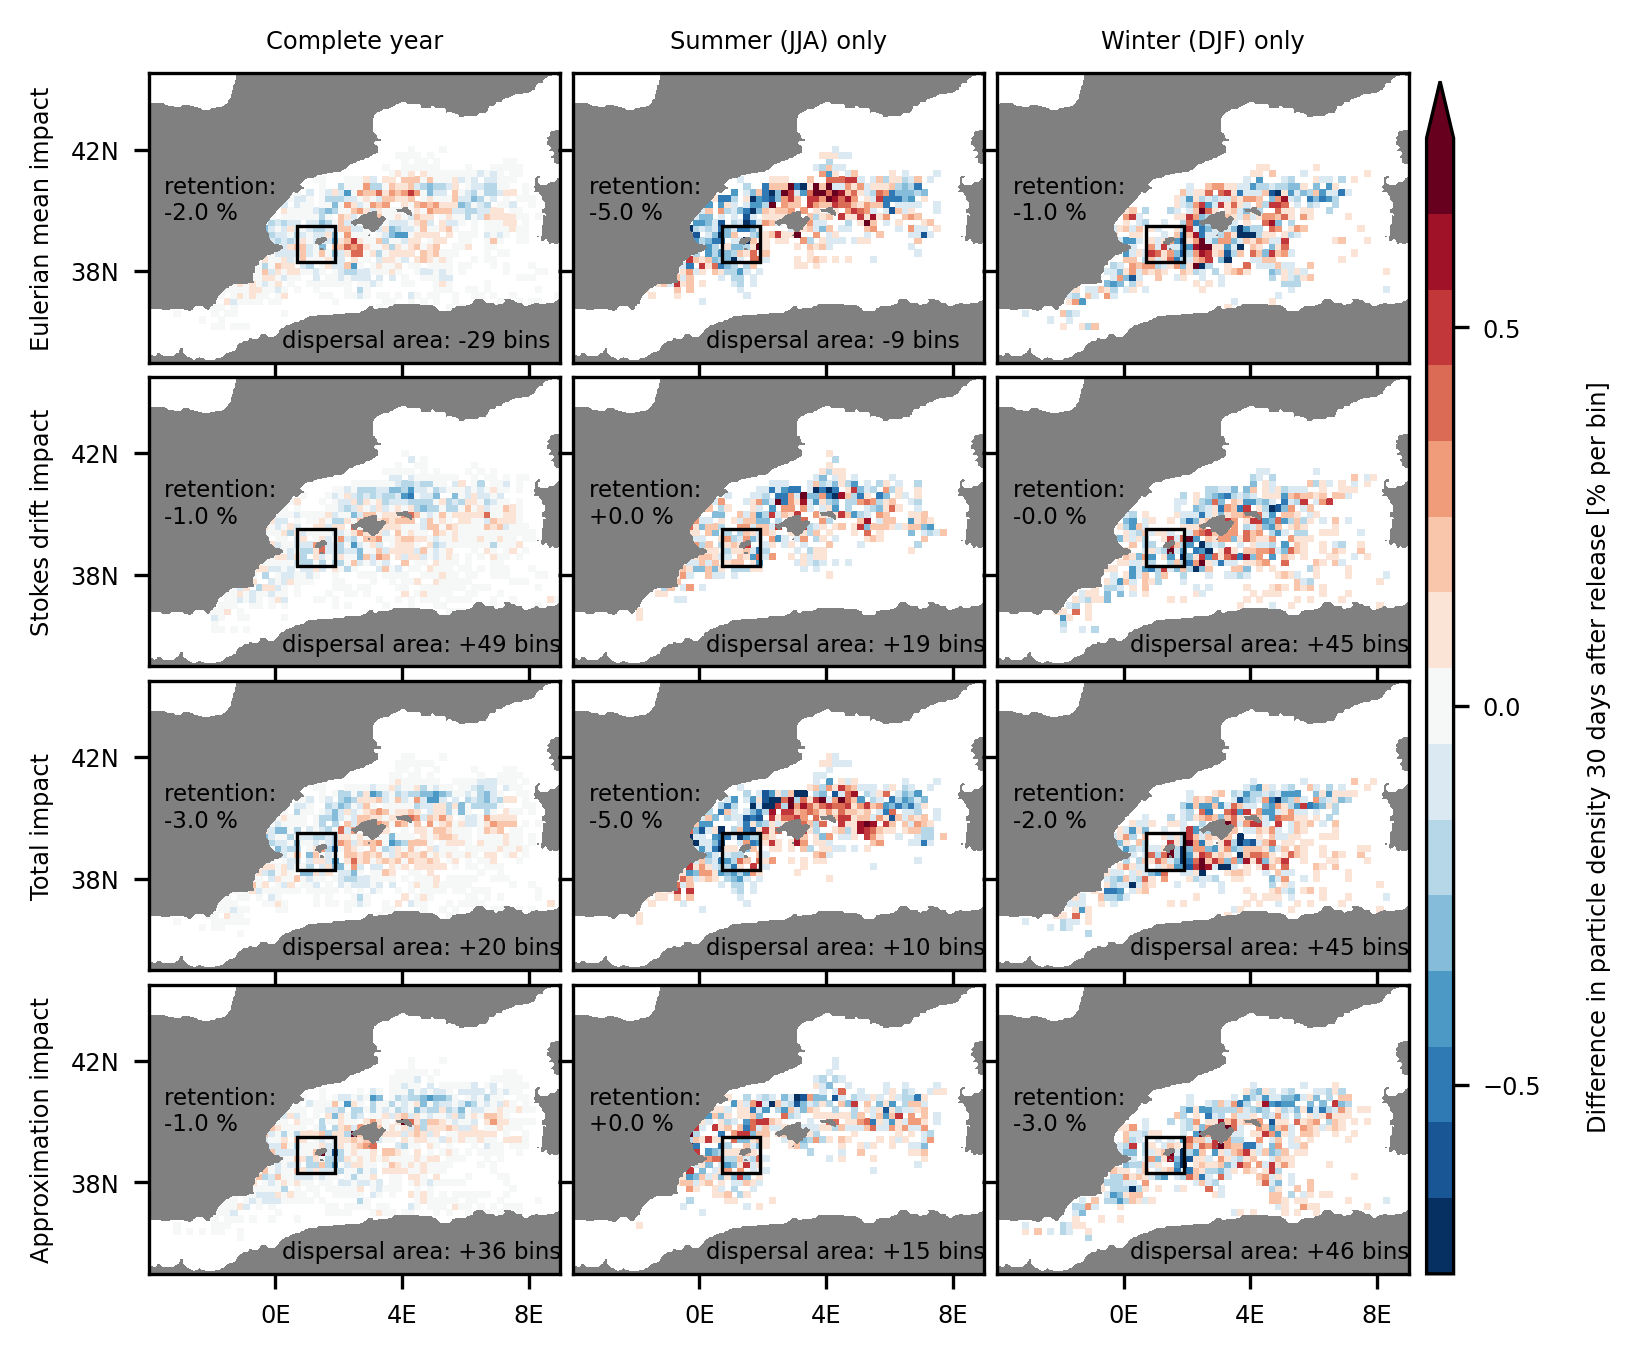

In [43]:
bins_lon = np.arange(-6,36,0.2); bins_lat =  np.arange(30.1,47,0.2)
lonmin = 0.7
lonmax = 1.901
latmin = 38.3
latmax = 39.5
step = 0.2
lonmin_plot = -4
lonmax_plot = 9
latmin_plot = 35
latmax_plot = 44.5
col_nc = 'grey'
col_csd = 'darkblue'
col_cnosd = 'lightblue'
col_ncsd = 'lightcoral'

colm = cm.RdBu_r 
levs = np.arange(-0.8, 0.8, 0.1)
norm = colors.BoundaryNorm(boundaries=levs+0.05, ncolors=colm.N)
fs='xx-small'
nctic=3

def plot_2Dhistdiff(var1,var2):
    pos_1y = var1.isel(obs=30).lat.stack(trajstack=('traj','start'))
    pos_1x = var1.isel(obs=30).lon.stack(trajstack=('traj','start'))
    hist2D_1 = histogram(pos_1x, pos_1y, bins=[bins_lon, bins_lat])
    hist2D_plot_1 = hist2D_1.transpose()/hist2D_1.sum().values*100
    pos_2y = var2.isel(obs=30).lat.stack(trajstack=('traj','start'))
    pos_2x = var2.isel(obs=30).lon.stack(trajstack=('traj','start'))
    hist2D_2 = histogram(pos_2x, pos_2y, bins=[bins_lon, bins_lat])
    hist2D_plot_2 = hist2D_2.transpose()/hist2D_2.sum().values*100
    hist2ddiff = hist2D_plot_1 - hist2D_plot_2
    map = ax.pcolor(hist2ddiff.lon_bin, hist2ddiff.lat_bin,
                    hist2ddiff.where(hist2ddiff != 0),
                    cmap=colm, norm=norm,
                    shading='nearest')
    #plt.colorbar(map)
    release_box = (((hist2D_plot_1.lon_bin >= lonmin) & (hist2D_plot_1.lon_bin <= lonmax)) &
                   ((hist2D_plot_1.lat_bin >= latmin) & (hist2D_plot_1.lat_bin <= latmax)))
    retention1 = hist2D_plot_1.where(release_box).sum()
    retention2 = hist2D_plot_2.where(release_box).sum()
    retentiondiff = retention1 - retention2
    if retentiondiff < 0:
        ax.annotate('retention: \n-' + str(np.abs(retentiondiff.round().values)) + ' %', (-3.5, latmax+step), fontsize=5.5)
    if retentiondiff > 0:
        ax.annotate('retention: \n+' + str(retentiondiff.round().values) + ' %', (-3.5, latmax+step), fontsize=5.5)
    area_bins_1 = (hist2D_plot_1.where(hist2D_plot_1 != 0)/hist2D_plot_1.where(hist2D_plot_1 != 0)).sum()
    area_bins_2 = (hist2D_plot_2.where(hist2D_plot_2 != 0)/hist2D_plot_2.where(hist2D_plot_2 != 0)).sum()
    area_bins_diff = area_bins_1 - area_bins_2
    if area_bins_diff < 0:
        ax.text(0.2, 35.5, 'dispersal area: -' + str(np.abs(int(area_bins_diff.round().values))) + ' bins', fontsize=5.5)
    if area_bins_diff > 0:
        ax.text(0.2, 35.5, 'dispersal area: +' + str(int(area_bins_diff.round().values)) + ' bins', fontsize=5.5)
    return map
    
def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')

def plot_releasebox():
    rect = patches.Rectangle((lonmin, latmin), lonmax-lonmin, latmax-latmin, 
                             linewidth=0.8,edgecolor='k', facecolor='none')
    ax.add_patch(rect)

def build_subplot(var1,var2,xticklabel=True,yticklabel=True):
    map = plot_2Dhistdiff(var1,var2)
    plot_bathy()
    plot_releasebox()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks([0,4,8])
    ax.set_yticks([38,42])
    ax.set_xticklabels(['0E','4E','8E'])
    ax.set_yticklabels(['38N','42N'])
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map

    
fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.1, right=0.8,
                      wspace=0.03, hspace=0.05)


# Totel distributions

ax = fig.add_subplot(gs[0,0])
var1 = traj_cnosd
var2 = traj_nc
map = build_subplot(var1,var2,xticklabel=False)
ax.set_title('Complete year', fontsize=fs)
ax.set_ylabel('Eulerian mean impact', fontsize=fs)

ax = fig.add_subplot(gs[1,0])
var1 = traj_csd
var2 = traj_cnosd
map = build_subplot(var1,var2,xticklabel=False)
ax.set_ylabel('Stokes drift impact', fontsize=fs)

ax = fig.add_subplot(gs[2,0])
var1 = traj_csd
var2 = traj_nc
map = build_subplot(var1,var2,xticklabel=False)
ax.set_ylabel('Total impact', fontsize=fs)

ax = fig.add_subplot(gs[3,0])
var1 = traj_ncsd
var2 = traj_nc
map = build_subplot(var1,var2)
ax.set_ylabel('Approximation impact', fontsize=fs)

# Summer distributions

start_use = slice(31,49)

ax = fig.add_subplot(gs[0,1])
var1 = traj_cnosd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)
ax.set_title('Summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[1,1])
var1 = traj_csd.isel(start=start_use)
var2 = traj_cnosd.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[2,1])
var1 = traj_csd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3,1])
var1 = traj_ncsd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,yticklabel=False)


#Winter distributions

start1 = np.arange(0,12); start2 = np.arange(67,73); start_use = [*l1, *l2]

ax = fig.add_subplot(gs[0,2])
var1 = traj_cnosd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)
ax.set_title('Winter (DJF) only', fontsize=fs)

ax = fig.add_subplot(gs[1,2])
var1 = traj_csd.isel(start=start_use)
var2 = traj_cnosd.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[2,2])
var1 = traj_csd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3,2])
var1 = traj_ncsd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,yticklabel=False)
ax.text(15, 52, 'Difference in particle density 30 days after release [% per bin]',
        ha='center', va='center', fontsize=fs, rotation=90)
cbaxes = fig.add_axes([0.81, 0.125, 0.015, 0.75])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()


In [ ]:
#var1 = traj_cnosd
#pos_y = var1.isel(obs=30).lat.stack(trajstack=('traj','start'))
#pos_x = var1.isel(obs=30).lon.stack(trajstack=('traj','start'))
#hist2D = histogram(pos_x, pos_y, bins=[bins_lon, bins_lat])
#hist2D_plot = hist2D.transpose()/hist2D.sum().values*100
#hist2D_plot_londiff = hist2D_plot.where(hist2D_plot !=0).diff('lon_bin').stack(lonlatstack=('lon_bin','lat_bin'))
#hist2D_plot_latdiff = hist2D_plot.where(hist2D_plot !=0).diff('lat_bin').stack(lonlatstack=('lon_bin','lat_bin'))
#bins = np.arange(0,1,0.05)
#histgradlon = histogram(xr.ufuncs.fabs(hist2D_plot_londiff), bins=[bins])
#histgradlat = histogram(xr.ufuncs.fabs(hist2D_plot_latdiff), bins=[bins])
#plt.plot(histgradlat.histogram_lon_lat_bin, histgradlat)

In [ ]:
fs1 = 7
fs2 = 5
lw1 = 1
col_csd = 'darkred'
col_nc = 'darkblue'
col_grid = 'grey'
alpha = 0.3
alpha2 = 0.1
tmin = 1
tmax = 31
tticks = (1,11,21,31)
tticklabs = ('0', '10', '20', '30')


fig = plt.figure(figsize=(3,6),dpi=300)

ax = plt.subplot2grid((4,1),(0,0), rowspan=1, colspan=1)
var_csd = dist_csd_quantiles / 1000
var_nc = dist_nc_quantiles / 1000
ymin = 0
ymax = 850
def plot_main():
    ax.grid(True, linestyle='dotted', which='major', color=col_grid, alpha=0.5)
    plt.plot(var_nc.obs+1,var_nc.isel(quantile=2),
             color=col_nc, linewidth=lw1,
             label='not coupled: median')
    plt.fill_between(var_nc.obs+1,
                     var_nc.isel(quantile=1),var_nc.isel(quantile=3),
                     alpha=alpha, color=col_nc,
                     label='not coupled: interquart. range')
    plt.fill_between(var_nc.obs+1,
                     var_nc.isel(quantile=0),var_nc.isel(quantile=1),
                     alpha=alpha2, color=col_nc,
                     label='not coupled: total range')
    plt.fill_between(var_nc.obs+1,
                     var_nc.isel(quantile=3),var_nc.isel(quantile=4),
                     alpha=alpha2, color=col_nc)
    plt.plot(var_csd.obs+1,var_csd.isel(quantile=2),
             color=col_csd, linewidth=lw1,
             label='coupled$_{sd}$: median')
    plt.fill_between(var_csd.obs+1,
                     var_csd.isel(quantile=1),var_csd.isel(quantile=3),
                     alpha=alpha, color=col_csd,
                     label='coupled$_{sd}$: interquart. range')
    plt.fill_between(var_csd.obs+1,
                     var_csd.isel(quantile=0),var_csd.isel(quantile=1),
                     alpha=alpha2, color=col_csd,
                     label='coupled$_{sd}$: total range')
    plt.fill_between(var_csd.obs+1,
                     var_csd.isel(quantile=3),var_csd.isel(quantile=4),
                     alpha=alpha2, color=col_csd)
    ax.set_xlim(tmin,tmax);
    ax.set_ylim(ymin,ymax);
    ax.set_xticks(tticks); ax.set_xticklabels([])
    ax.tick_params(axis='both', labelsize=fs1)
plot_main()
ax.set_ylabel('Absolute displacement \n$d(t)$ [$km$]', fontsize=fs1)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
          ncol=2, mode="expand", borderaxespad=0.,
         fontsize=fs2, handlelength = 1.0)

ax = plt.subplot2grid((4,1),(1,0), rowspan=1, colspan=1)
ymin = 0
ymax = 400
var_csd = (resdist_total_csd_quantiles) / 1000
var_nc = (resdist_total_nc_quantiles) / 1000
plot_main()
ax.set_ylabel('\n$d^,_{total}(t)$ [$km$]', fontsize=fs1)

ax = plt.subplot2grid((4,1),(2,0), rowspan=1, colspan=1)
ymin = 0
ymax = 400
var_csd = (resdist_space_csd_quantiles) / 1000
var_nc = (resdist_space_nc_quantiles) / 1000
plot_main()
ax.set_ylabel('Relative displacements \n$d^,_{space}(t)$ [$km$]', fontsize=fs1)

ax = plt.subplot2grid((4,1),(3,0), rowspan=1, colspan=1)
ymin = 0
ymax = 400
var_csd = (resdist_time_csd_quantiles) / 1000
var_nc = (resdist_time_nc_quantiles) / 1000
plot_main()
ax.set_xticklabels(tticklabs)
ax.set_ylabel('\n$d^,_{time}(t)$ [$km$]', fontsize=fs1)
ax.set_xlabel('time after release [days]', fontsize=fs1)

plt.subplots_adjust(bottom=0.1, left=0.1, right=0.9, top=0.9,
                    wspace=0.00, hspace=0.06)


In [ ]:
fs1 = 7
fs2 = 5
lw1 = 1
col_csd = 'darkred'
col_nc = 'darkblue'
col_grid = 'grey'
alpha = 0.3
alpha2 = 0.1
tmin = 1
tmax = 31
tticks = (1,11,21,31)
tticklabs = ('0', '10', '20', '30')


fig = plt.figure(figsize=(3,6),dpi=300)

ax = plt.subplot2grid((4,1),(0,0), rowspan=1, colspan=1)
var_csd = dist_cnosd_quantiles / 1000
var_nc = dist_nc_quantiles / 1000
ymin = 0
ymax = 850
def plot_main():
    ax.grid(True, linestyle='dotted', which='major', color=col_grid, alpha=0.5)
    plt.plot(var_nc.obs+1,var_nc.isel(quantile=2),
             color=col_nc, linewidth=lw1,
             label='not coupled: median')
    plt.fill_between(var_nc.obs+1,
                     var_nc.isel(quantile=1),var_nc.isel(quantile=3),
                     alpha=alpha, color=col_nc,
                     label='not coupled: interquart. range')
    plt.fill_between(var_nc.obs+1,
                     var_nc.isel(quantile=0),var_nc.isel(quantile=1),
                     alpha=alpha2, color=col_nc,
                     label='not coupled: total range')
    plt.fill_between(var_nc.obs+1,
                     var_nc.isel(quantile=3),var_nc.isel(quantile=4),
                     alpha=alpha2, color=col_nc)
    plt.plot(var_csd.obs+1,var_csd.isel(quantile=2),
             color=col_csd, linewidth=lw1,
             label='coupled$_{nosd}$: median')
    plt.fill_between(var_csd.obs+1,
                     var_csd.isel(quantile=1),var_csd.isel(quantile=3),
                     alpha=alpha, color=col_csd,
                     label='coupled$_{nosd}$: interquart. range')
    plt.fill_between(var_csd.obs+1,
                     var_csd.isel(quantile=0),var_csd.isel(quantile=1),
                     alpha=alpha2, color=col_csd,
                     label='coupled$_{nosd}$: total range')
    plt.fill_between(var_csd.obs+1,
                     var_csd.isel(quantile=3),var_csd.isel(quantile=4),
                     alpha=alpha2, color=col_csd)
    ax.set_xlim(tmin,tmax);
    ax.set_ylim(ymin,ymax);
    ax.set_xticks(tticks); ax.set_xticklabels([])
    ax.tick_params(axis='both', labelsize=fs1)
plot_main()
ax.set_ylabel('Absolute displacement \n$d(t)$ [$km$]', fontsize=fs1)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
          ncol=2, mode="expand", borderaxespad=0.,
         fontsize=fs2, handlelength = 1.0)

ax = plt.subplot2grid((4,1),(1,0), rowspan=1, colspan=1)
ymin = 0
ymax = 400
var_csd = (resdist_total_cnosd_quantiles) / 1000
var_nc = (resdist_total_nc_quantiles) / 1000
plot_main()
ax.set_ylabel('\n$d^,_{total}(t)$ [$km$]', fontsize=fs1)

ax = plt.subplot2grid((4,1),(2,0), rowspan=1, colspan=1)
ymin = 0
ymax = 400
var_csd = (resdist_space_cnosd_quantiles) / 1000
var_nc = (resdist_space_nc_quantiles) / 1000
plot_main()
ax.set_ylabel('Relative displacements \n$d^,_{space}(t)$ [$km$]', fontsize=fs1)

ax = plt.subplot2grid((4,1),(3,0), rowspan=1, colspan=1)
ymin = 0
ymax = 400
var_csd = (resdist_time_cnosd_quantiles) / 1000
var_nc = (resdist_time_nc_quantiles) / 1000
plot_main()
ax.set_xticklabels(tticklabs)
ax.set_ylabel('\n$d^,_{time}(t)$ [$km$]', fontsize=fs1)
ax.set_xlabel('time after release [days]', fontsize=fs1)

plt.subplots_adjust(bottom=0.1, left=0.1, right=0.9, top=0.9,
                    wspace=0.00, hspace=0.06)



In [ ]:
fig, axs = plt.subplots(4,3,figsize=(12,9))
tticks = (1,11,21,31)
tticklabs = ('1', '11', '21', '31')

var = dist_csd.stack(trajstack=('traj','start')).transpose() / 1000
var2 = dist_csd_quantiles / 1000
axs[0,0].boxplot(var,0,'',whis=[1,100])
axs[0,0].plot(var2.obs+1,var2.isel(quantile=0))
axs[0,0].plot(var2.obs+1,var2.isel(quantile=2))
axs[0,0].plot(var2.obs+1,var2.isel(quantile=1))
axs[0,0].plot(var2.obs+1,var2.isel(quantile=3))
axs[0,0].plot(var2.obs+1,var2.isel(quantile=4))
axs[0,0].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_total_csd.stack(trajstack=('traj','start')).transpose()) / 1000
axs[1,0].boxplot(var,0,'')
axs[1,0].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_space_csd.stack(trajstack=('traj','start')).transpose()) / 1000
axs[2,0].boxplot(var,0,'')
axs[2,0].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_time_csd.stack(trajstack=('traj','start')).transpose()) / 1000
axs[3,0].boxplot(var,0,'')
axs[3,0].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')


var = dist_cnosd.stack(trajstack=('traj','start')).transpose() / 1000
axs[0,1].boxplot(var,0,'')
axs[0,1].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_total_cnosd.stack(trajstack=('traj','start')).transpose()) / 1000
axs[1,1].boxplot(var,0,'')
axs[1,1].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_space_cnosd.stack(trajstack=('traj','start')).transpose()) / 1000
axs[2,1].boxplot(var,0,'')
axs[2,1].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_time_cnosd.stack(trajstack=('traj','start')).transpose()) / 1000
axs[3,1].boxplot(var,0,'')
axs[3,1].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')


var = dist_nc.stack(trajstack=('traj','start')).transpose() / 1000
axs[0,2].boxplot(var,0,'')
axs[0,2].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_total_nc.stack(trajstack=('traj','start')).transpose()) / 1000
axs[1,2].boxplot(var,0,'')
axs[1,2].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_space_nc.stack(trajstack=('traj','start')).transpose()) / 1000
axs[2,2].boxplot(var,0,'')
axs[2,2].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_time_nc.stack(trajstack=('traj','start')).transpose()) / 1000
axs[3,2].boxplot(var,0,'')
axs[3,2].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')



#axs[1].boxplot(abs(resdist_total_csd)/1000,0,'')
#axs[1].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')